# HW 3+4 CSCI 5525 Fall 2025 (Prof. Paul Schrater):

In this problem you will develop and train neural networks on the QMNIST dataset, moving the objective from digit classification to more complex tasks using joint prediction over groups of digits.

We will be using this single dataset as an exemplar to understand key ideas:

Developing domain models leads to particular network architectures and training procedures that:
    * Require inputting data as point sets, not points
    * Produce multiple overlapping paths between input data and output predictions.
    * Require penalizing additional cross-prediction losses, generated by forcing the network to predict missing parts (masked) of the input set from remaining parts.  
    * Use ubiquitous tokenization to make every varible a potential target, and ubiquitous embeddings to ensure the network can discover compatible representations using only a few computational motifs.

 - ### Background ideas:
  - *Domain models require predictive consistency*: The problem represents an exemplar of strategies needed to develop _domain models_ that allow for predicting any subset of variables from any other subset of variables.  
  - *Multiple predictions=Multiple Paths*: Because neural networks are computational graphs, every distinct prediction needs to be computed as a *path* from input variables to output variables.  For multiple predictions, we get multiple paths.  However, if we train each path separately, the predictions we can be (e.g. will be) inconsistent!
  - *Consistency needs shared embeddings*: In addition, we want to let the neural network learn (optimize) its own internal representations (embeddings). If we allow separate embeddings for each path, the predictions can become inconsistent again! This motivates neural network architectures that share embeddings across prediction paths. - - *Consistency needs to be enforced during optimization*: To ensure that joint predictions are consistent, we can add a set of loss functions that penalize inconsistency.  From an optimization point of view, these act as constraints, which means we can add these (weighted) constraints losses onto our prediction loss and train using standard gradient methods.  
  - *Theoretical basis of solution ideas*:
      - *Derive all predictions from same joint distribution*:
      - *Each prediction takes the form*:

              p(target variables | non-target variables)
      
      Recall the chain rule in probability:  
              p(x1,x2,x3)
                  = p(x3|x2,x1)p(x2|x1)p(x1)
                  = p(x3|x1,x2)p(x1|x2)p(x2)
                  = p(x2|x1,x3)p(x1|x3)p(x3)
                  = p(x2|x3,x1)p(x3|x1)p(x1)
                  = p(x1|x2,x3)p(x2|x3)p(x3)
                  = p(x1|x3,x2)p(x3|x2)p(x2)

     - *Each decomposition is a prediction task _and_ a computational path, with the path moving from conditioning to predicted variables.
     We can insert embedding variables ubiquitously by inserting in the chain:
              p(x1,x2,x3) = Sum_z  p(x1,z1,x2,z2,x3,z3) etc.
              = Sum_z p(x3|z3)p(z3|z12)p(z12|z2,z1)p(z2|x2,z1)p(z1|x1)
              etc.


     - *Taking logs of the decompositions decomposes losses additively AND yields Networks!*: Turn product to sum above!


## *Problem 1* (40 pts):
Using the QMNIST dataset, create a procedure to create balanced subsets of jointly labeled QMNIST data. 



In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from itertools import *
from more_itertools import *
from functools import *
from collections import *
import torch.nn.functional as F
from sympy import *
import ssl
import os


def lookup_table(f: dict, x: list):
  y = [f[k] for k in x]
  return y

# Fix SSL issues before connecting to torch in local environment
certifi_path = ssl.get_default_verify_paths().cafile
if not certifi_path:
    try:
        import certifi
        certifi_path = certifi.where()
    except ImportError:
        print("certifi is not installed. Please install it: pip install certifi")
        exit()

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

training_data = datasets.QMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.QMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# 60K training points
Ntrain = len(training_data)

# focus on data from High School students.  According to NIST, these have the most difficult samples
HSidx = [idx for idx,target in enumerate(training_data.targets) if target[1]==4] # filter to HFS series trget[i] == 4

# subset the data, separating images and targets
train_ims = training_data.data[HSidx] 
train_targets = training_data.targets[HSidx]
Nsamples = len(train_ims)

# create new data id for subset
dat_idx = list(range(Nsamples)) #list of ints 1-Nsamples

# we will look at digits by class AND writer (id of student who wrote the digit)
tl = train_targets[:,0].tolist() # digit label
tw = train_targets[:,2].tolist() # digit author index

# which writer ids are in hfs 4?
writersidx = list(unique_everseen(tw)) # find unique writer list
# how many?  250
Nwriters=len(writersidx)

# Make indicator Vector representations of indices.  This allows better match between math and computation
# convert label indices into set of one hot vectors.  H for "Hot".  These are glorified identity matrices!
Hlabel = F.one_hot(torch.arange(0, 10) % 10, num_classes=10)
Hwriter = F.one_hot(torch.arange(0, Nwriters) % (Nwriters), num_classes=Nwriters)

# convert the unique writer id into an hfs local version.  Makes indexing im tensor easier
w_idx = list(range(Nwriters))
# put in correspondence with original ids
w_dict = dict(zip(writersidx,w_idx))

## Writer indices shifted to [0,249]
# create simple functional map between original and new indices
twi = lookup_table(w_dict,tw) # digit author list local to hfs 4

# reshape images into column vectors
ims =(1/255)*train_ims.type(torch.float32).reshape([len(train_ims),28*28]).T


# Assign label one-hot indicator vectors to each sample.
Il = Hlabel[:,tl]
Iw = Hwriter[:,twi]

# wrap data up as a tuple
# data = (ims,Il,Iw)


In [25]:
print(Il.shape)

torch.Size([10, 29050])


In [29]:
#split the tuple into 5 balanced subsets - 
#                               I'm interpreting "balanced" as in, there are
#                               an equal number of dually-labeled images in each subset

num_subsets = 5 #choosing 5 subsets; not sure what a reasonable number might be here
num_images = ims.size(1)  # Nimages = Ncols, since we set them up as cols in the reshape

image_subset_sizes = [num_images // num_subsets] * num_subsets
remainder = num_images % num_subsets #take a remainder in case we change the subset size later
for i in range(remainder):
    image_subset_sizes[i] += 1 #distribute extra samples in case we change the subset size and it's not evenly divisible

balanced_subsets = []
start_index = 0
for size in image_subset_sizes:
    end_index = start_index + size #take a subset-sized chunk
    subset_ims = ims[:, start_index:end_index]
    subset_Il = Il[:, start_index:end_index]
    subset_Iw = Iw[:, start_index:end_index]
    balanced_subsets.append((subset_ims, subset_Il, subset_Iw))
    start_index = end_index #start next time where we leave off this time

# Verify the shapes of the subsets
for i, subset in enumerate(balanced_subsets):
    print(f"Subset {i+1}:")
    print(f"  Images shape: {subset[0].shape}")
    print(f"  Labels shape: {subset[1].shape}")
    print(f"  Writers shape: {subset[2].shape}")
    print('\n')

Subset 1:
  Images shape: torch.Size([784, 5810])
  Labels shape: torch.Size([10, 5810])
  Writers shape: torch.Size([250, 5810])


Subset 2:
  Images shape: torch.Size([784, 5810])
  Labels shape: torch.Size([10, 5810])
  Writers shape: torch.Size([250, 5810])


Subset 3:
  Images shape: torch.Size([784, 5810])
  Labels shape: torch.Size([10, 5810])
  Writers shape: torch.Size([250, 5810])


Subset 4:
  Images shape: torch.Size([784, 5810])
  Labels shape: torch.Size([10, 5810])
  Writers shape: torch.Size([250, 5810])


Subset 5:
  Images shape: torch.Size([784, 5810])
  Labels shape: torch.Size([10, 5810])
  Writers shape: torch.Size([250, 5810])






## *Problem 2* (40 pts):  
Use the joint decomposition idea above to formalize the objective of jointly predicting digit labels and writer ids.  of two label types $(y_{d},y_{w})$ representing one-hot vectors for digit class (0-9) and writer identity from digit images $x_{im}$ for _balanced groupings_ of data samples, we will feed into the network simultaneously.  

The joint prediction problem can be ubiquitously written as two conditional prediction problems:

- $p(y_{d},y_{w}|z_{im}) = p(y_{d}|z_{im},y_{w})*p(y_{w}|z_{im})*p(z_{im}|X_{im})$

and

- $p(y_{d},y_{w}|z_{im}) = p(y_{w}|z_{im},y_{d})*p(y_{d}|z_{im})*p(z_{im}|X_{im})$

These two decompositions must be equal, producing a constraint.

Taking logs of both objectives, we get:
  - $z_{w→d}=\log(y_{d},y_{w}) = \text{net}_{y_{d}}(z_{im},y_{w}) + \text{net}_{y_{w}}(z_{im}) + \text{net}_{z}(X_{im})$

and

 - $z_{d→w}=\log(y_{d},y_{w})_{w→d} = \text{net}_{y_{d}}(z_{im},y_{w}) + \text{net}_{y_{w}}(z_{im}) + \text{net}_{z}(X_{im})$

where

 - $\text{net}_{y_{pred}}(\text{in}_1,\text{in}_2) = \log(y_{pred}|\text{in}_1,\text{in}_2)$

For every prediction, use softmax to make estimates, and cross entropy loss as an objective.  For example,
 - $(\hat{y}_d,\hat{y}_w)_{w→d} = \text{softmax}(z_{w→d})$
 - $(\hat{y}_d,\hat{y}_w)_{d→w} = \text{softmax}(z_{d→w})$
 - $\ell((\hat{y}_d,\hat{y}_w)_{w→d},(y_d,y_w)) = \text{crossentropy}(z_{d→w},(y_d,y_w))$

 Where there are multiple paths to the same prediction, introduce a consistency loss.  For example,

 - $\ell_{constraint} = \text{crossentropy}((\hat{y}_d,\hat{y}_w)_{w→d},(y_d,y_w),(\hat{y}_d,\hat{y}_w)_{w→d},(y_d,y_w))$

Write out the equations and block diagram for your joint prediction model. There should be multiple components that can be trained separately as well as joint prediction components, as well as cross-prediction components.


In [ ]:
# please see attached PDF for equations and diagram



## * Problem 3* (40 pts)  
Implement your architecture in Pytorch.  You can use different ideas, but the simplest is to extend the base model which can be rapidly trained for the $y_d$ prediction sub-problem.

The base model is [here](https://colab.research.google.com/drive/14-wDnBbh2TEiWjBdELsmyp7rUxS6w1-i?usp=sharing)


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import v2
from torch.utils.data import TensorDataset

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import IProgress

import copy
import random
import time

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred, h_2

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def MLPobjective(yhat,y):
    l = F.cross_entropy(yhat,y)
    return l

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

ROOT = 'data'

train_data = datasets.QMNIST(root=ROOT,
                            train=True,
                            download=True)
test_data = datasets.QMNIST(root=ROOT,
                           train=False,
                           download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

ind = torch.randperm(len(train_data))
train_ind = ind[:n_train_examples]
valid_ind = ind[n_train_examples+1:]

train_transforms = transforms.Compose([
                            v2.RandomRotation(5, fill=(0,)),
                            v2.RandomCrop(28, padding=2),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.ToTensor(),
                            v2.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           v2.ToDtype(torch.float32, scale=True),
                           v2.ToTensor(),
                           v2.Normalize(mean=[mean], std=[std])
                                     ])


train_ims = train_transforms(train_data.data[train_ind])
train_targets = train_data.targets[train_ind]

valid_ims = test_transforms(train_data.data[valid_ind])
valid_targets = train_data.targets[valid_ind]

test_ims = test_transforms(test_data.data)
test_targets = test_data.targets

train_data = TensorDataset(train_ims,train_targets)
valid_data = TensorDataset(valid_ims,valid_targets)
test_data = TensorDataset(test_ims,test_targets)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

# we can get one sample using an iterator:
train_features, train_labels = next(iter(train_iterator))
train_features.shape



INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

print(f'The model has {count_parameters(model):,} trainable parameters')


optimizer = optim.Adam(model.parameters())

criterion = MLPobjective

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



Exception ignored in: <function tqdm.__del__ at 0x30a4936a0>
Traceback (most recent call last):
  File "/Users/meridethbain/Documents/csci-5525/.venv/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/meridethbain/Documents/csci-5525/.venv/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x30a4936a0>
Traceback (most recent call last):
  File "/Users/meridethbain/Documents/csci-5525/.venv/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/meridethbain/Documents/csci-5525/.venv/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
/Users/meridethbain/Documents/csci

Calculated mean: 0.13083340227603912
Calculated std: 0.308803915977478
Number of training examples: 54000
Number of validation examples: 5999
Number of testing examples: 60000
The model has 222,360 trainable parameters


In [44]:
#training the model
import IProgress

#TODO: i ran into an intractable error here where I was unable to train the base model because of an import error,
#but the package recommended by the error message is already installed.
#without being able to run the base model, I was unable to expand it.

model = []
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())
model = model.to(device)



EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, train_iterator,criterion, device)#valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## *Problem 4*: (40 pts)
 The dataset, QMNIST is a richer version of the standard with information about both the digit writer and the cohort.

 The idea is that the data has additional two-level graph structure.  Images are connected by where they came from: a cohort given by HFS id, and a writer within that cohort given by writer id.

 For all the problems we will be feeding the network images in batches FROM THE SAME writers.  That will require a common modification of the way we feed in data, and forms the shared problems.

## *Problem 5*: (40 pts)
Plot training loss separately for all component objectives, and train the joint prediction layer using a weighted sum of the joint prediction crossentropy loss and the constraint losses. Ensure joint prediction weight is higher than the sum of the constraint weights.

Finally, develop a procedure to randomly "perturb" the images and labels and use that to improve your estimate of true generalization error.  

 You are welcome to share code and ideas for these  problems.

## Advice

The homework will require solving key subproblems, and there are important hints and implementation details which make the problem much more tractable:

1.  Standard layers are not so good - too constrained.  Try "ragged" layers or rewrite the basic MLP replacing linear layers with einsum. In addition, use masked tensors to allow for contiguous batches that can be trained on the masked prediction tasks.  Some hints:
  - Einops, einsum background [here](https://einops.rocks/pytorch-examples.html)
  - Use a masked tensor as an input layer, which allows passing a mask input that turns off some elements of the input batch.

2.Rewrite the DataLoader with the following modifications:
  - Define a collate_fn that defines batches as follows. Each batch has 10 images from 6 authors for 60 total, one of each digit, ordered by digit id.  
  
  - Define a 1x60 mask vector that determines which digits will be predicted in the batch.
  
  - Augment the target to include writer id and digit id.

  - Augment the network to accept image batch, mask, and an id vector.


In all cases, the minimal target is to identify BOTH DIGIT LABEL AND AUTHOR ID from batches of images FROM THE SAME WRITER.

Full credit is given for a network that runs on the data and can produce better than chance prediction on the joint task.  

You do NOT have to use the templates, but you should be able to show that you have directed modified the neural network to adapt to our problem.  

Adapting code is challenging.  You are encouraged to share hints and tips and group work is allowed.

## Extra Credit opportunities

  * (25 pts) Implement gMLP and apply the QMNIST dataset,
Background [here](https://wandb.ai/sauravmaheshkar/gMLP/reports/Bringing-Back-MLPs--Vmlldzo4MTM1NTc), a code template is [here](https://nn.labml.ai/transformers/gmlp/index.html).  

  * (30 pts) Implement a neural network that solves the batching problem, use it instead of the dataloader.
  
  * (30 pts) Implement a simple transformer layer and apply to QMNIST dataset task, a code template is [here](https://nn.labml.ai/transformers/models.html).  Here the positional encodings _are the sample index_. The reason we batch the data in order of increasing digit is so that the digits will appear in fixed relative locations.The reason we batch the data in order of increasing digit is so that the digits will appear in fixed relative locations.
  
  * (30 pts) Augment the image data with positional encodings based on any reasonable idea and add these encodings to the image embeddings in the extended MLP networks. One alternative can be to use the embeddings discovered in the problem below


  * (30 pts) Implement graph embeddings.  

      - Nodes are writers (writer index = w)
      - Define edge weights as follows:
      - For each digit class (d), compute the average digit image $m_d$.
    - For each writer (w), compute the average distance between $m_d$ and writer's images of that class $r_{w,d}$ = mean(dist($im_{w,d}$,$m_d$)). You can choose any reasonable measure of distance you like.  
    - For each pair of writers, let the signed edge weight vector $E_{w_1,w_2}(d)$ be given by the difference $r_{w,d}$ - mean(dist($im_{w_1,d}$,$im_{w_2,d})$. That gives 10 values per writer pair.
    - Let the overall edge weight $e_{w_1,w_2} = sign(E_{w_1,w_2})max(abs(E_{w_1,w_2}))$ the largest positive or difference of the pair away from average.
    - Using [here](https://colab.research.google.com/drive/1vvIoEqxGl1naopTZbh4bmCOLEiCxvcQq) problem #3 as a template, implement graph embeddings for the writer network.

    * (25 pts) Implement GraphSage. Ideally adapt the code from [here](https://colab.research.google.com/drive/18PQ-B2wDmomjPtHroLNg_aH3hFniLNKn#scrollTo=TQy2RBfgYut4)

    * (25 pts) Implement neural tanget kernel for QMNIST. Background [here](https://colab.research.google.com/github/pytorch/pytorch/blob/master/functorch/notebooks/neural_tangent_kernels.ipynb#scrollTo=99a38a4b-64d3-4e13-bd63-2d71e8dd6840)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# utility routine
def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

# Illustrating new concepts using old standards

The MNIST dataset is tried and true for explaining ML concepts. In this homework we develop modern viewpoints using an improved version of an old standard.  

## QMNIST

The exact preprocessing steps used to construct the [MNIST dataset](http://yann.lecun.com/exdb/mnist) have long been lost. This leaves us with no reliable way to associate its characters with the ID of the writer and little hope to recover the full MNIST testing set that had 60K images but was never released. The official MNIST testing set only contains 10K randomly sampled images and is often considered too small to provide meaninful confidence intervals.

The **QMNIST** dataset was generated from the original data found in the [NIST Special Database 19](https://www.nist.gov/srd/nist-special-database-19) with the goal to match the MNIST preprocessing as closely as possible.

We will work with the QMNIST dataset, which has the full set of 60K images, but with augmented labels.  The label tensor is a two-dimensional tensor of integers (`idx2-int`) with 8 columns:

| Column | Description  | Range |
|:------:|--------------|-------|
| 0 | Character class | 0 to 9
| 1 | NIST HSF series | 0, 1, or 4
| 2 | NIST writer ID | 0-610 and 2100-2599  
| 3 | Digit index for this writer | 0 to 149
| 4 | NIST class code | 30-39
| 5 | Global NIST digit index | 0 to 281769
| 6 | Duplicate | 0
| 7 | Unused | 0

The hsf field refers to the original partition of data collection across different field offices of NIST [see pub](https://s3.amazonaws.com/nist-srd/SD19/sd19_users_guide_edition_2.pdf).  Partition $hsf_4$ was completed by the Bethesda high school students, and all other partitions $hsf_{0,1,2,3,6,7,8}$ were collected by the Census Bureau.

The below focuses on the hsf 4 sample (HS students).

You will need to separate samples by author.

Load pytorch and the data:


In [ ]:
import torch.utils.data as data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import datasets
from torchvision.transforms import v2


train_data = datasets.QMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.QMNIST(
    root="data",
    train=False,
    download=True
)

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

ind = torch.randperm(len(train_data))
train_ind = ind[:n_train_examples]
valid_ind = ind[n_train_examples+1:]

minimal_transforms = transforms.Compose([v2.ToImage(),
                                         v2.ToDtype(torch.float32, scale=True)])

train_ims = minimal_transforms(train_data.data[train_ind])
train_targets = train_data.targets[train_ind]

valid_ims = minimal_transforms(train_data.data[valid_ind])
valid_targets = train_data.targets[valid_ind]

test_ims = minimal_transforms(test_data.data)
test_targets = test_data.targets

train_data = TensorDataset(train_ims,train_targets)
valid_data = TensorDataset(valid_ims,valid_targets)
test_data = TensorDataset(test_ims,test_targets)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# set up iterators
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

100%|██████████| 9.70M/9.70M [00:00<00:00, 149MB/s]
100%|██████████| 463k/463k [00:00<00:00, 20.3MB/s]
100%|██████████| 9.74M/9.74M [00:00<00:00, 127MB/s]
100%|██████████| 527k/527k [00:00<00:00, 17.7MB/s]


Number of training examples: 54000
Number of validation examples: 5999
Number of testing examples: 60000


In [ ]:
train_targets[:10]


tensor([[     7,      0,    138,     49,     37,  14887,      0,      0],
        [     0,      4,   2242,     91,     30, 239673,      0,      0],
        [     8,      4,   2301,    102,     38, 246583,      0,      0],
        [     1,      4,   2158,     47,     31, 229886,      0,      0],
        [     2,      4,   2165,     99,     32, 230746,      0,      0],
        [     0,      0,     93,     10,     30,   9834,      0,      0],
        [     8,      4,   2241,     83,     38, 239547,      0,      0],
        [     4,      4,   2216,     62,     34, 236611,      0,      0],
        [     7,      0,     81,     85,     37,   8651,      0,      0],
        [     9,      4,   2325,     34,     39, 249343,      0,      0]])

We can get a look at some of the images within our dataset to see what we're working with. The function below plots a square grid of images. If you supply less than a complete square number of images it will ignore the last few.

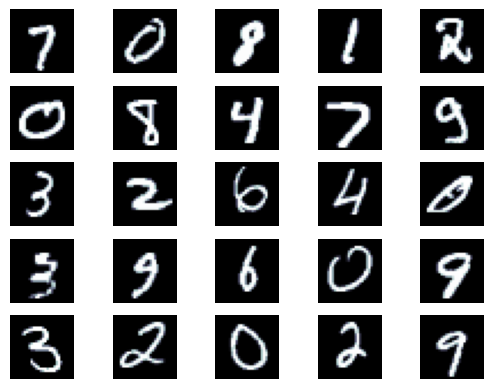

In [ ]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)